# Character level language model - Dinosaurus Island

We are in charge of a special task: Leading biology researchers are creating new breeds of dinosaurs and bringing them to life on earth, and our job is to give names to these dinosaurs. If a dinosaur does not like its name, it might go berserk, so choose wisely! 

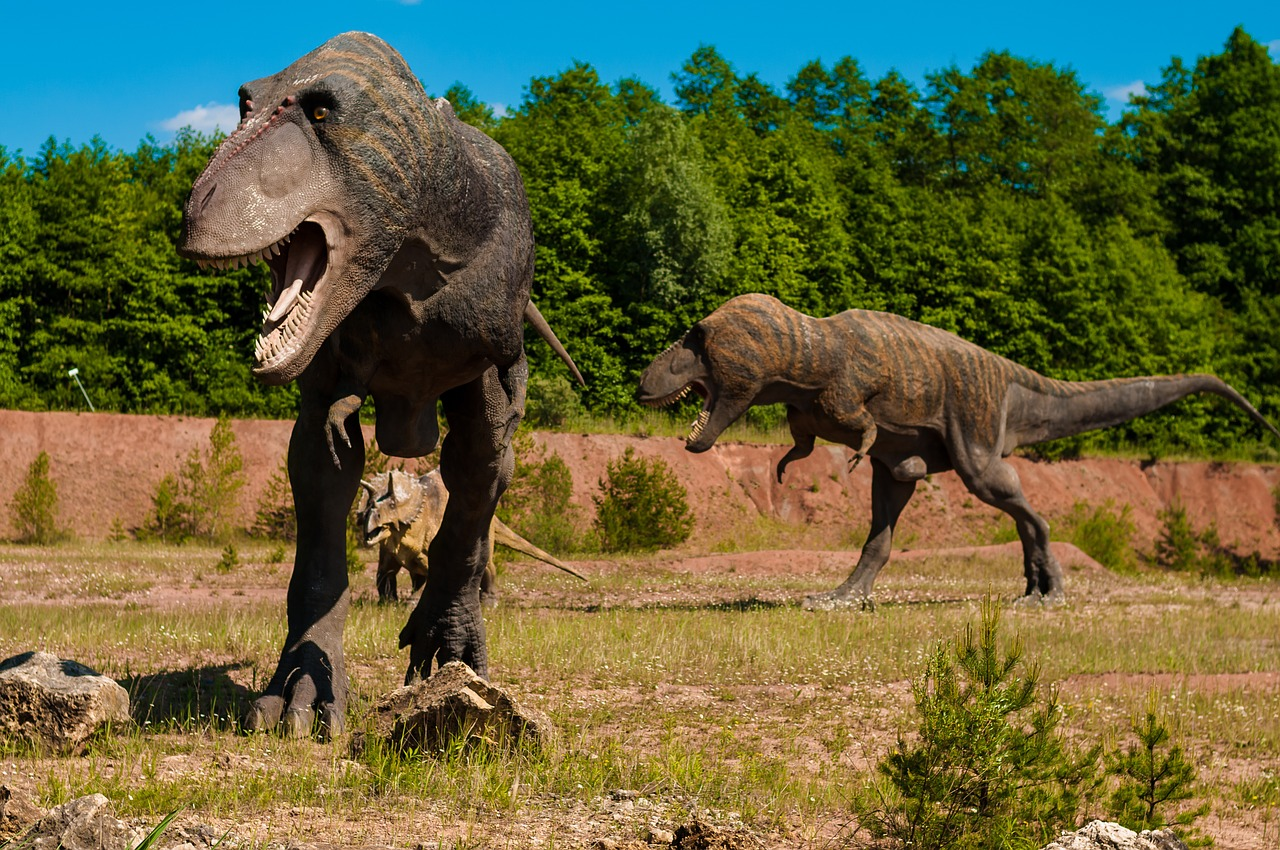

Luckily we're equipped with some deep learning now, and we will use it to save the day! Your assistant has collected a list of all the dinosaur names they could find, and compiled them into this [dataset](dinos.txt). To create new dinosaur names, we will build a character-level language model to generate new names. our algorithm will learn the different name patterns, and randomly generate new names.

By the time we complete this notebook, we'll be able to:

* Store text data for processing using an RNN 
* Build a character-level text generation model using an RNN
* Sample novel sequences in an RNN
* Explain the vanishing/exploding gradient problem in RNNs
* Apply gradient clipping as a solution for exploding gradients

#### Packages

In [ ]:
import numpy as np
from utils import *
import random
import pprint
import copy

## Problem Statement


### Dataset and Preprocessing 

In [ ]:
data = open('dinos.txt', 'r').read()
data= data.lower()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

In [ ]:
chars = sorted(chars)
print(chars)

In [ ]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(ix_to_char)

### Overview of the Model

Model structure: 

- Initialize parameters 
- Run the optimization loop
    - Forward propagation to compute the loss function
    - Backward propagation to compute the gradients with respect to the loss function
    - Clip the gradients to avoid exploding gradients
    - Using the gradients, update your parameters with the gradient descent update rule.
- Return the learned parameters 
    
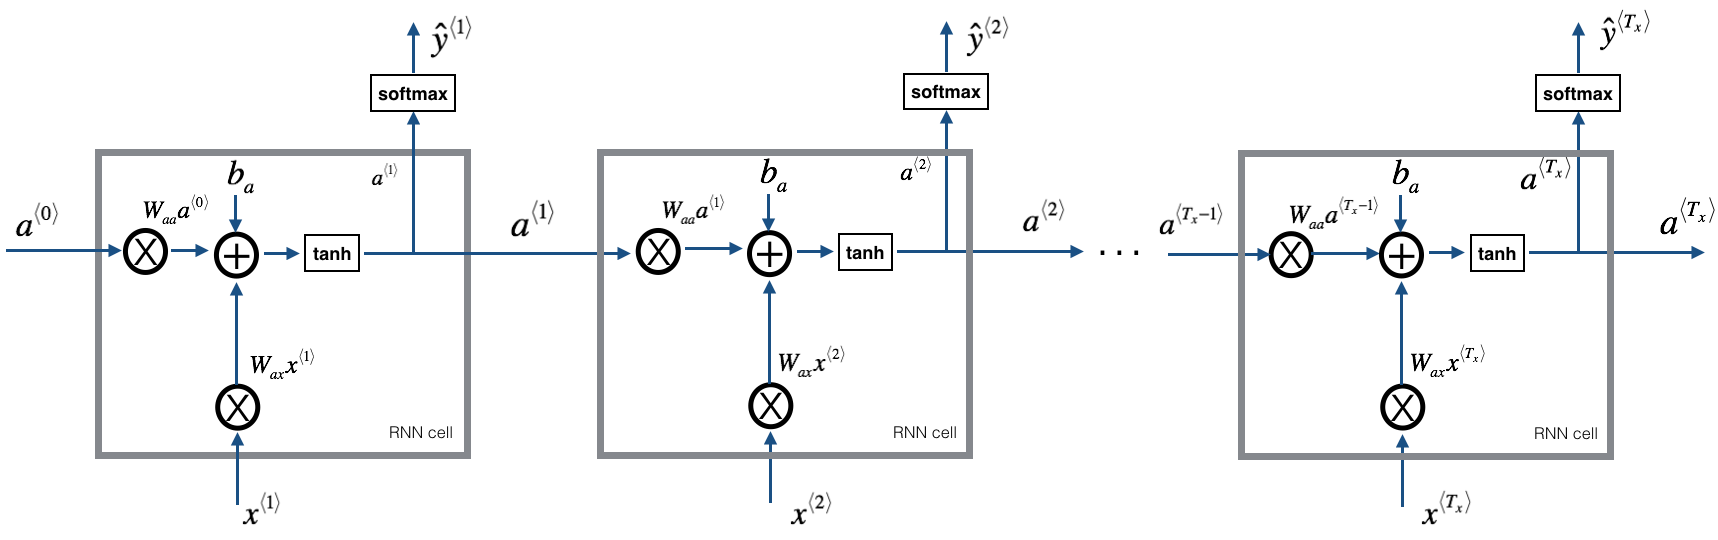
<caption><center><font color='purple'><b>Figure 1</b>: Recurrent Neural Network, similar to what you built in the previous notebook "Building a Recurrent Neural Network - Step by Step."  </center></caption>

* At each time-step, the RNN tries to predict what the next character is, given the previous characters. 
* $\mathbf{X} = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ is a list of characters from the training set.
* $\mathbf{Y} = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$ is the same list of characters but shifted one character forward. 
* At every time-step $t$, $y^{\langle t \rangle} = x^{\langle t+1 \rangle}$.  The prediction at time $t$ is the same as the input at time $t + 1$.

## Building Blocks of the Model

We will build two important blocks of the overall model:

1. Gradient clipping: to avoid exploding gradients
2. Sampling: a technique used to generate characters

We will then apply these two functions to build the model.

### Clipping the Gradients in the Optimization Loop

In this section we will implement the `clip` function that you will call inside of our optimization loop. 

#### Exploding gradients
* When gradients are very large, they're called "exploding gradients."  
* Exploding gradients make the training process more difficult, because the updates may be so large that they "overshoot" the optimal values during back propagation.

Recall that our overall loop structure usually consists of:
* forward pass, 
* cost computation, 
* backward pass, 
* parameter update. 

Before updating the parameters, we will perform gradient clipping to make sure that your gradients are not "exploding."

#### Gradient clipping
We will implement a function `clip` that takes in a dictionary of gradients and returns a clipped version of gradients, if needed. 

* There are different ways to clip gradients.
* We will use a simple element-wise clipping procedure, in which every element of the gradient vector is clipped to fall between some range [-N, N]. 
* For example, if the N=10
    - The range is [-10, 10]
    - If any component of the gradient vector is greater than 10, it is set to 10.
    - If any component of the gradient vector is less than -10, it is set to -10. 
    - If any components are between -10 and 10, they keep their original values.

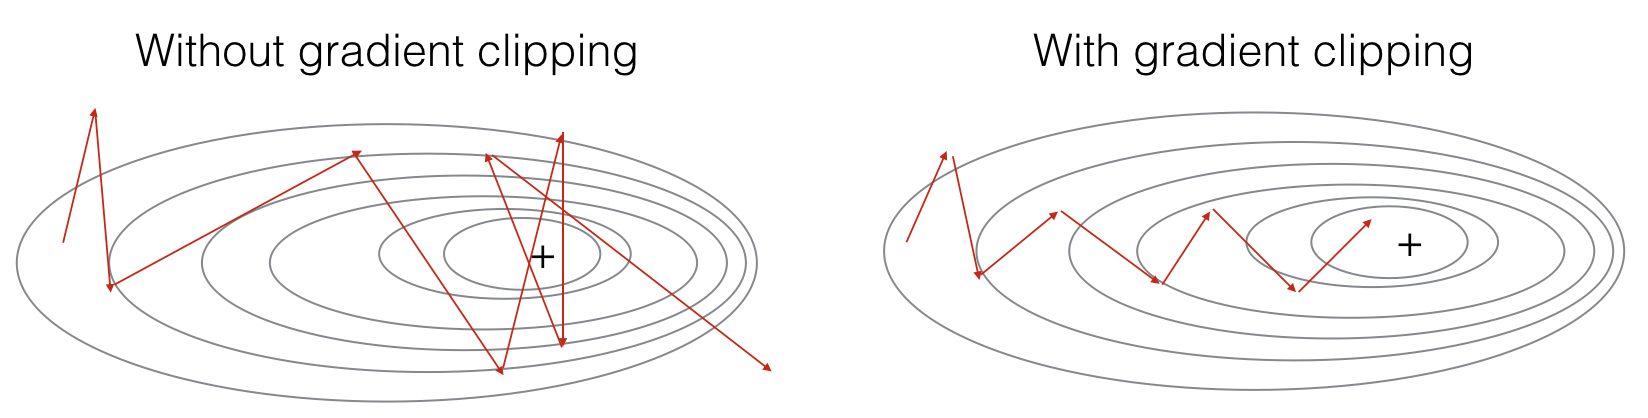
<caption><center><font color='purple'><b>Figure 2</b>: Visualization of gradient descent with and without gradient clipping, in a case where the network is running into "exploding gradient" problems. </center></caption>

In [ ]:
def clip(gradients, maxValue):
    '''
    Clips the gradients' values between minimum and maximum.
    
    Arguments:
    gradients -- a dictionary containing the gradients "dWaa", "dWax", "dWya", "db", "dby"
    maxValue -- everything above this number is set to this number, and everything less than -maxValue is set to -maxValue
    
    Returns: 
    gradients -- a dictionary with the clipped gradients.
    '''
    gradients = copy.deepcopy(gradients)
    
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
   
    # Clip to mitigate exploding gradients, loop over [dWax, dWaa, dWya, db, dby].
    for gradient in [dWax, dWaa, dWya, db, dby]:
        np.clip(gradient, -maxValue, maxValue, out = gradient)
    
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients

### Sampling

Now, assume that our model is trained, and we would like to generate new text (characters). The process of generation is explained in the picture below:

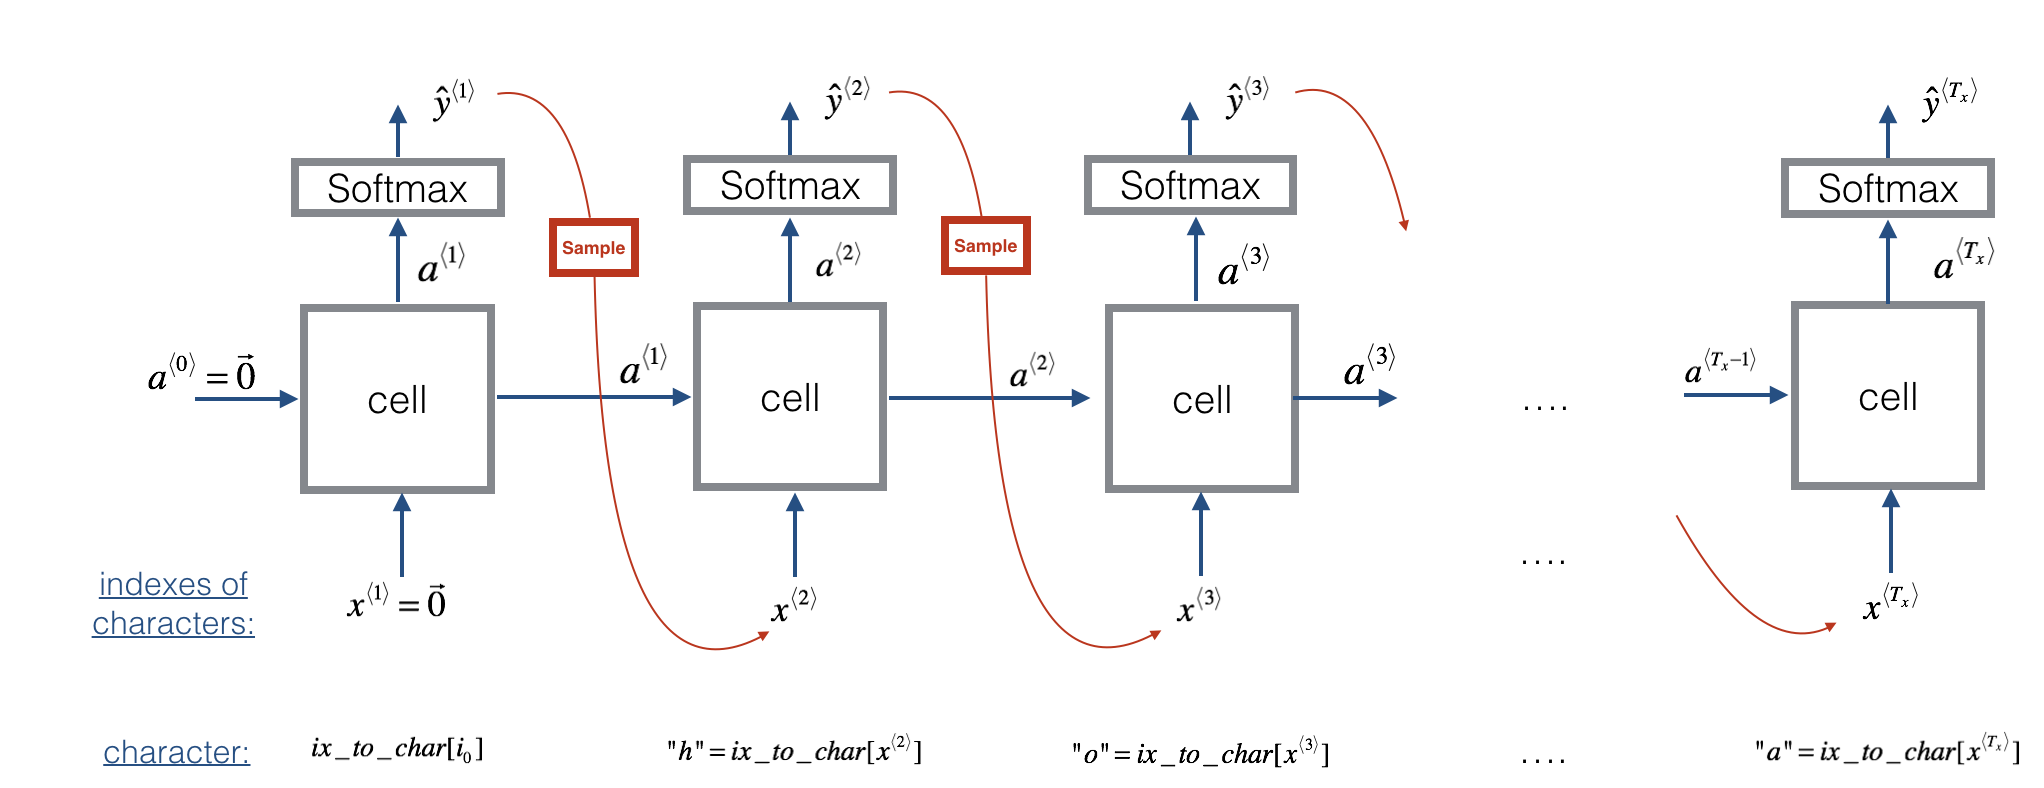
<caption><center><font color='purple'><b>Figure 3</b>: In this picture, we can assume the model is already trained. We pass in $x^{\langle 1\rangle} = \vec{0}$ at the first time-step, and have the network sample one character at a time. </center></caption>

In [ ]:
def sample(parameters, char_to_ix, seed):
    """
    Sample a sequence of characters according to a sequence of probability distributions output of the RNN

    Arguments:
    parameters -- Python dictionary containing the parameters Waa, Wax, Wya, by, and b. 
    char_to_ix -- Python dictionary mapping each character to an index.
    seed -- Used for grading purposes. Do not worry about it.

    Returns:
    indices -- A list of length n containing the indices of the sampled characters.
    """
    
    # Retrieve parameters and relevant shapes from "parameters" dictionary
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]
    
    # Create the a zero vector x that can be used as the one-hot vector 
    # Representing the first character (initializing the sequence generation). 
    x = np.zeros((vocab_size, 1))
    # Initialize a_prev as zeros 
    a_prev = np.zeros((n_a, 1))
    
    # Create an empty list of indices. This is the list which will contain the list of indices of the characters to generate 
    indices = []
    
    # idx is the index of the one-hot vector x that is set to 1
    # All other positions in x are zero.
    # Initialize idx to -1
    idx = -1
    
    # Loop over time-steps t. At each time-step:
    # Sample a character from a probability distribution 
    # And append its index (`idx`) to the list "indices". 
    # You'll stop if you reach 50 characters 
    # (which should be very unlikely with a well-trained model).
    # Setting the maximum number of characters helps with debugging and prevents infinite loops. 
    counter = 0
    newline_character = char_to_ix['\n']
    
    while (idx != newline_character and counter != 50):
        
        # Forward propagate x using the equations (1), (2) and (3)
        a = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b)
        z = np.dot(Wya, a) + by
        y = softmax(z)
        
        # For grading purposes
        np.random.seed(counter + seed) 
        
        # Sample the index of a character within the vocabulary from the probability distribution y
        idx = np.random.choice(list(range(vocab_size)), p = y.ravel())

        # Append the index to "indices"
        indices.append(idx)
        
        # Overwrite the input x with one that corresponds to the sampled index `idx`.
        x = np.zeros((vocab_size, 1))
        x[idx] = 1
        
        # Update "a_prev" to be "a"
        a_prev = a
        
        # for grading purposes
        seed += 1
        counter +=1

    if (counter == 50):
        indices.append(char_to_ix['\n'])
    
    return indices

<font color='blue'><b>What to remember</b>: 
* Very large, or "exploding" gradients updates can be so large that they "overshoot" the optimal values during back prop -- making training difficult 
    * Clip gradients before updating the parameters to avoid exploding gradients 
* Sampling is a technique you can use to pick the index of the next character according to a probability distribution.
    * To begin character-level sampling: 
        * Input a "dummy" vector of zeros as a default input 
        * Run one step of forward propagation to get 𝑎⟨1⟩ (your first character) and 𝑦̂ ⟨1⟩ (probability distribution for the following character) 
        * When sampling, avoid generating the same result each time given the starting letter (and make your names more interesting!) by using `np.random.choice`

## Building the Language Model 

It's time to build the character-level language model for text generation! 


### Gradient Descent 

We will implement a function performing one step of stochastic gradient descent (with clipped gradients). we'll go through the training examples one at a time, so the optimization algorithm will be stochastic gradient descent. 

As a reminder, here are the steps of a common optimization loop for an RNN:

- Forward propagate through the RNN to compute the loss
- Backward propagate through time to compute the gradients of the loss with respect to the parameters
- Clip the gradients
- Update the parameters using gradient descent 

In [7]:
def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    """
    Execute one step of the optimization to train the model.
    
    Arguments:
    X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
    Y -- list of integers, exactly the same as X but shifted one index to the left.
    a_prev -- previous hidden state.
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    learning_rate -- learning rate for the model.
    
    Returns:
    loss -- value of the loss function (cross-entropy)
    gradients -- python dictionary containing:
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
                        db -- Gradients of bias vector, of shape (n_a, 1)
                        dby -- Gradients of output bias vector, of shape (n_y, 1)
    a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
    """
    
    # Forward propagate through time 
    loss, cache = rnn_forward(X, Y, a_prev, parameters)
    
    # Backpropagate through time 
    gradients, a = rnn_backward(X, Y, parameters, cache)
    
    # Clip your gradients between -5 (min) and 5 (max) 
    gradients = clip(gradients, 5)
    
    # Update parameters 
    parameters = update_parameters(parameters, gradients, learning_rate)
    
    return loss, gradients, a[len(X)-1]

### Training the Model 

* Given the dataset of dinosaur names, we'll use each line of the dataset (one name) as one training example. 
* Every 2000 steps of stochastic gradient descent, we will sample several randomly chosen names to see how the algorithm is doing. 

When `examples[index]` contains one dinosaur name (string), to create an example (X, Y), you can use this:

##### Set the index `idx` into the list of examples

* Using the for-loop, walk through the shuffled list of dinosaur names in the list "examples."
* For example, if there are n_e examples, and the for-loop increments the index to n_e onwards, think of how you would make the index cycle back to 0, so that you can continue feeding the examples into the model when j is n_e, n_e + 1, etc.
* Hint: (n_e + 1) % n_e equals 1, which is otherwise the 'remainder' you get when you divide (n_e + 1) by n_e.
* `%` is the [modulo operator in python](https://www.freecodecamp.org/news/the-python-modulo-operator-what-does-the-symbol-mean-in-python-solved/).

##### Extract a single example from the list of examples
* `single_example`: use the `idx` index that you set previously to get one word from the list of examples.

##### Convert a string into a list of characters: `single_example_chars`
* `single_example_chars`: A string is a list of characters.
* You can use a list comprehension (recommended over for-loops) to generate a list of characters.
```Python
str = 'I love learning'
list_of_chars = [c for c in str]
print(list_of_chars)
```

```
['I', ' ', 'l', 'o', 'v', 'e', ' ', 'l', 'e', 'a', 'r', 'n', 'i', 'n', 'g']
```

* For more on [list comprehensions](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions):

##### Convert list of characters to a list of integers: `single_example_ix`
* Create a list that contains the index numbers associated with each character.
* Use the dictionary `char_to_ix`
* You can combine this with the list comprehension that is used to get a list of characters from a string.

##### Create the list of input characters: `X`
* `rnn_forward` uses the **`None`** value as a flag to set the input vector as a zero-vector.
* Prepend the list [**`None`**] in front of the list of input characters.
* There is more than one way to prepend a value to a list.  One way is to add two lists together: `['a'] + ['b']`

##### Get the integer representation of the newline character `ix_newline`
* `ix_newline`: The newline character signals the end of the dinosaur name.
    - Get the integer representation of the newline character `'\n'`.
    - Use `char_to_ix`

##### Set the list of labels (integer representation of the characters): `Y`
* The goal is to train the RNN to predict the next letter in the name, so the labels are the list of characters that are one time-step ahead of the characters in the input `X`.
    - For example, `Y[0]` contains the same value as `X[1]`  
* The RNN should predict a newline at the last letter, so add `ix_newline` to the end of the labels. 
    - Append the integer representation of the newline character to the end of `Y`.
    - Note that `append` is an in-place operation.
    - It might be easier for you to add two lists together.

In [ ]:
def model(data_x, ix_to_char, char_to_ix, num_iterations = 35000, n_a = 50, dino_names = 7, vocab_size = 27, verbose = False):
    """
    Trains the model and generates dinosaur names. 
    
    Arguments:
    data_x -- text corpus, divided in words
    ix_to_char -- dictionary that maps the index to a character
    char_to_ix -- dictionary that maps a character to an index
    num_iterations -- number of iterations to train the model for
    n_a -- number of units of the RNN cell
    dino_names -- number of dinosaur names you want to sample at each iteration. 
    vocab_size -- number of unique characters found in the text (size of the vocabulary)
    
    Returns:
    parameters -- learned parameters
    """
    
    # Retrieve n_x and n_y from vocab_size
    n_x, n_y = vocab_size, vocab_size
    
    # Initialize parameters
    parameters = initialize_parameters(n_a, n_x, n_y)
    
    # Initialize loss (this is required because we want to smooth our loss)
    loss = get_initial_loss(vocab_size, dino_names)
    
    # Build list of all dinosaur names (training examples).
    examples = [x.strip() for x in data_x]
    
    # Shuffle list of all dinosaur names
    np.random.seed(0)
    np.random.shuffle(examples)
    
    # Initialize the hidden state of your LSTM
    a_prev = np.zeros((n_a, 1))
    
    # for grading purposes
    last_dino_name = "abc"
    
    # Optimization loop
    for j in range(num_iterations):
        
        # Set the index `idx` 
        idx = j % len(examples)
        
        # Set the input X 
        single_example = examples[idx]
        single_example_chars = [x for x in single_example]
        single_example_ix = [char_to_ix[x] for x in single_example_chars]
        X = [None] + single_example_ix
        
        # Set the labels Y 
        ix_newline = [char_to_ix['\n']]
        Y = X[1:] + ix_newline

        # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
        # Choose a learning rate of 0.01
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters)
        
        # debug statements to aid in correctly forming X, Y
        if verbose and j in [0, len(examples) -1, len(examples)]:
            print("j = " , j, "idx = ", idx,) 
        if verbose and j in [0]:
            print("single_example =", single_example)
            print("single_example_chars", single_example_chars)
            print("single_example_ix", single_example_ix)
            print(" X = ", X, "\n", "Y =       ", Y, "\n")
        
        # to keep the loss smooth.
        loss = smooth(loss, curr_loss)

        # Every 2000 Iteration, generate "n" characters thanks to sample() to check if the model is learning properly
        if j % 2000 == 0:
            
            print('Iteration: %d, Loss: %f' % (j, loss) + '\n')
            
            # The number of dinosaur names to print
            seed = 0
            for name in range(dino_names):
                
                # Sample indices and print them
                sampled_indices = sample(parameters, char_to_ix, seed)
                last_dino_name = get_sample(sampled_indices, ix_to_char)
                print(last_dino_name.replace('\n', ''))
                
                seed += 1  # To get the same result (for grading purposes), increment the seed by one. 
      
            print('\n')
        
    return parameters, last_dino_name

When we run the following cell, we should observe our model outputting random-looking characters at the first iteration. After a few thousand iterations, our model should learn to generate reasonable-looking names. 

In [9]:
parameters, last_name = model(data.split("\n"), ix_to_char, char_to_ix, 22001, verbose = True)

assert last_name == 'Trodonosaurus\n', "Wrong expected output"
print("\033[92mAll tests passed!")

j =  0 idx =  0
single_example = turiasaurus
single_example_chars ['t', 'u', 'r', 'i', 'a', 's', 'a', 'u', 'r', 'u', 's']
single_example_ix [20, 21, 18, 9, 1, 19, 1, 21, 18, 21, 19]
 X =  [None, 20, 21, 18, 9, 1, 19, 1, 21, 18, 21, 19] 
 Y =        [20, 21, 18, 9, 1, 19, 1, 21, 18, 21, 19, 0] 

Iteration: 0, Loss: 23.087336

Nkzxwtdmfqoeyhsqwasjkjvu
Kneb
Kzxwtdmfqoeyhsqwasjkjvu
Neb
Zxwtdmfqoeyhsqwasjkjvu
Eb
Xwtdmfqoeyhsqwasjkjvu


j =  1535 idx =  1535
j =  1536 idx =  0
Iteration: 2000, Loss: 27.884160

Liusskeomnolxeros
Hmdaairus
Hytroligoraurus
Lecalosapaus
Xusicikoraurus
Abalpsamantisaurus
Tpraneronxeros


Iteration: 4000, Loss: 25.901815

Mivrosaurus
Inee
Ivtroplisaurus
Mbaaisaurus
Wusichisaurus
Cabaselachus
Toraperlethosdarenitochusthiamamumamaon


Iteration: 6000, Loss: 24.608779

Onwusceomosaurus
Lieeaerosaurus
Lxussaurus
Oma
Xusteonosaurus
Eeahosaurus
Toreonosaurus


Iteration: 8000, Loss: 24.070350

Onxusichepriuon
Kilabersaurus
Lutrodon
Omaaerosaurus
Xutrcheps
Edaksoje
Trodi

### Conclusion

We can see that our algorithm has started to generate plausible dinosaur names towards the end of training. At first, it was generating random characters, but towards the end we could begin to see dinosaur names with cool endings. 

This model used a relatively small dataset, so that we're able to train an RNN quickly on a CPU. Training a model of the English language requires a much bigger dataset, and usually much more computation, and could run for many hours on GPUs. We ran our dinosaur name for quite some time, and so far our favorite name is the great, the fierce, the undefeated: **Mangosaurus**!

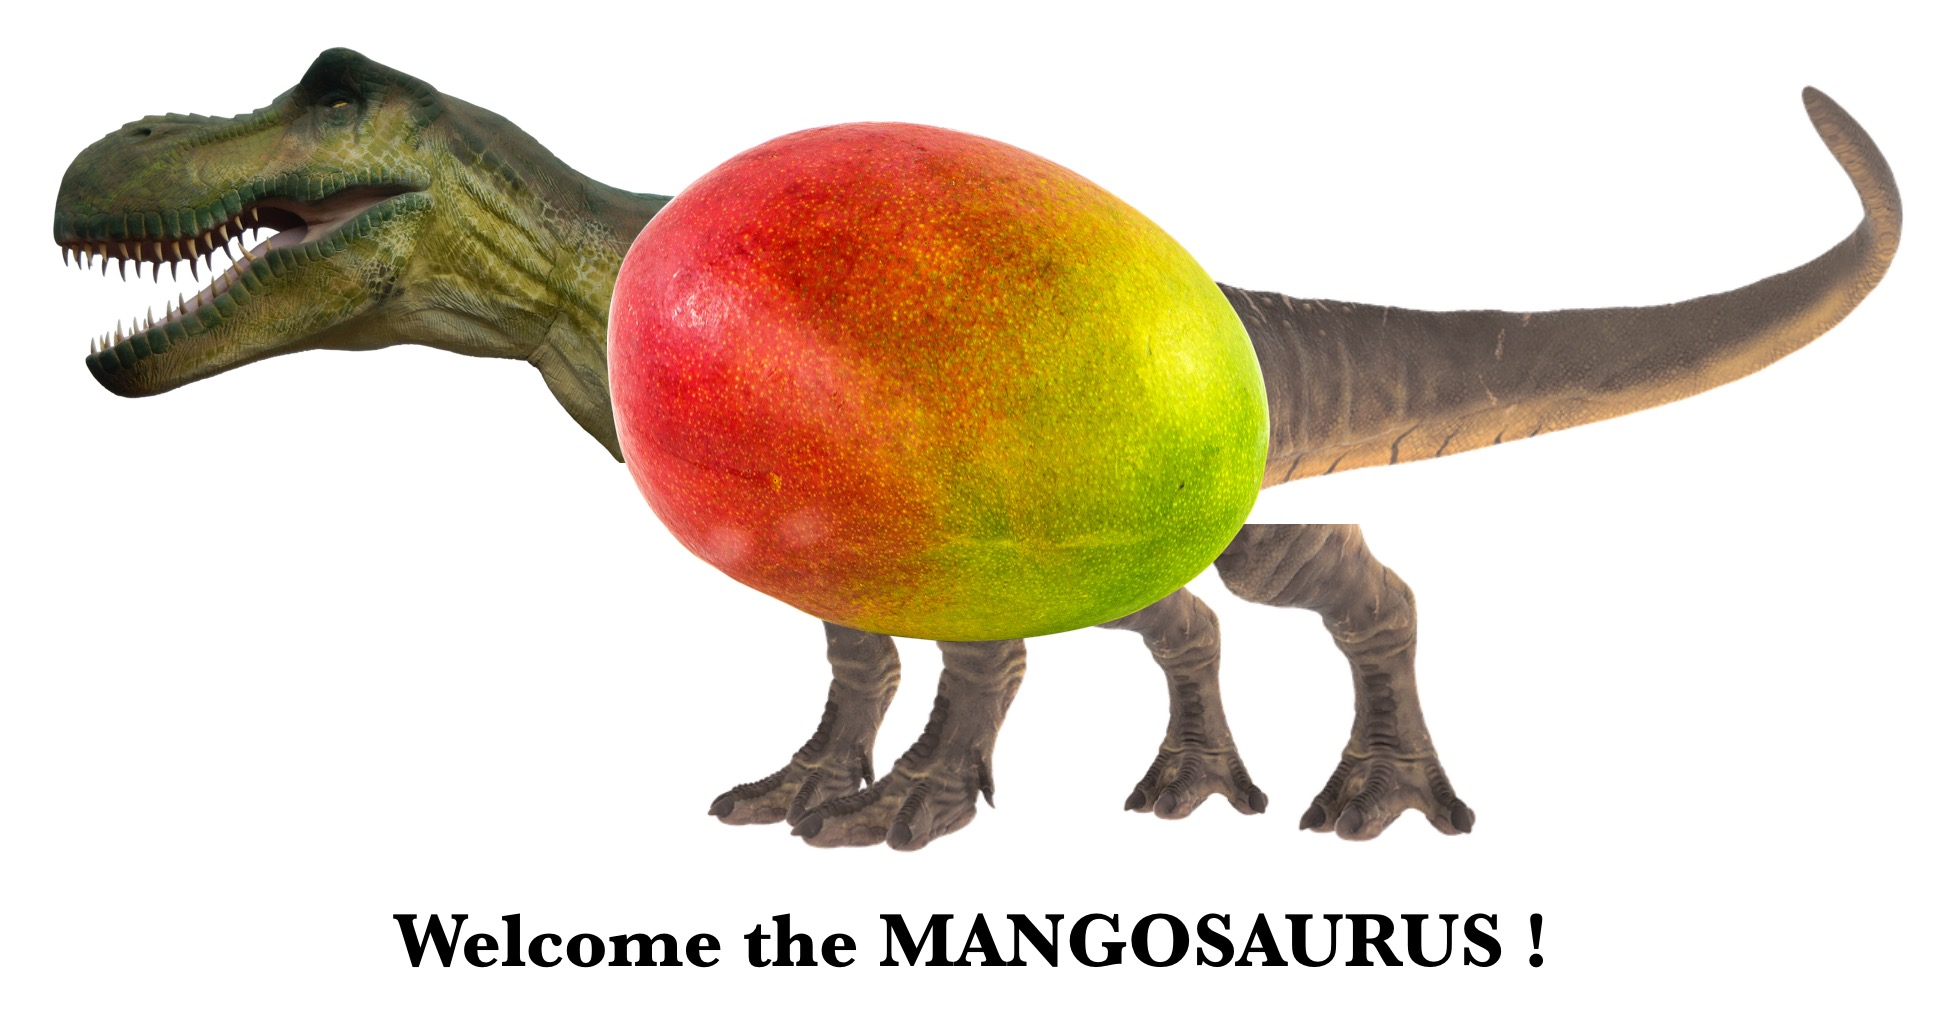

By now, we've: 

* Stored text data for processing using an RNN 
* Built a character-level text generation model
* Explored the vanishing/exploding gradient problem in RNNs
* Applied gradient clipping to avoid exploding gradients

## Writing like Shakespeare 

A similar task to character-level text generation (but more complicated) is generating Shakespearean poems. Instead of learning from a dataset of dinosaur names, we can use a collection of Shakespearean poems. Using LSTM cells, we can learn longer-term dependencies that span many characters in the text--e.g., where a character appearing somewhere a sequence can influence what should be a different character, much later in the sequence. These long-term dependencies were less important with dinosaur names, since the names were quite short. 


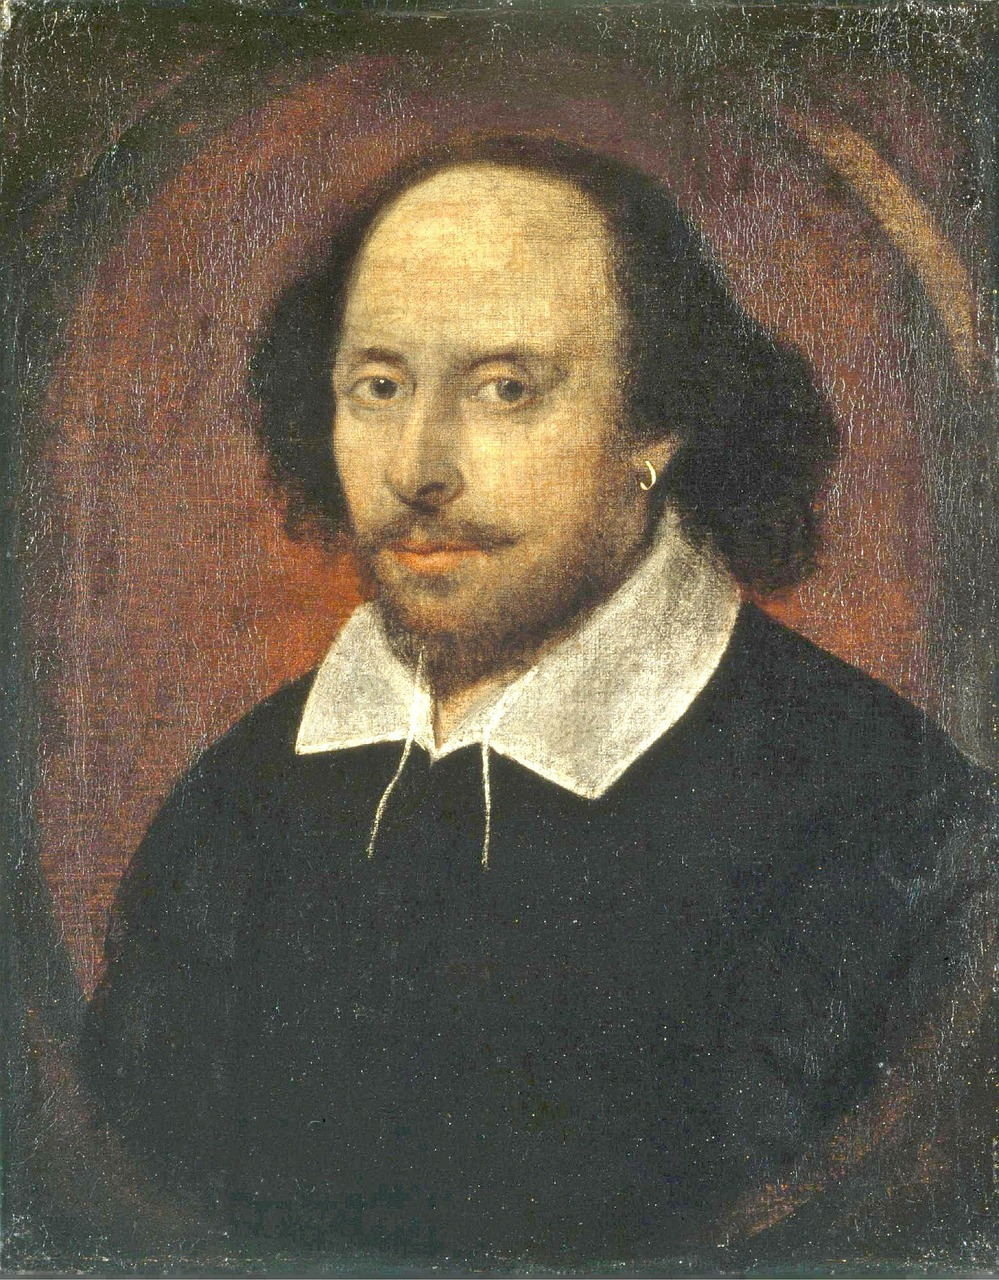
<caption><center><font color='purple'><b>Let's become poets!</b></center></caption>

In [ ]:
from __future__ import print_function
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from shakespeare_utils import *
import sys
import io

To save you some time, a model has already been trained for ~1000 epochs on a collection of Shakespearean poems called "<i>[The Sonnets](shakespeare.txt)</i>."

Let's train the model for one more epoch. When it finishes training for an epoch (this will also take a few minutes), we can run `generate_output`, which will prompt us for an input (`<`40 characters). The poem will start with our sentence, and our RNN Shakespeare will complete the rest of the poem for us! 

In [ ]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y, batch_size=128, epochs=1, callbacks=[print_callback])

In [12]:
# Run this cell to try with different inputs without having to re-train the model 
generate_output()

Write the beginning of your poem, the Shakespeare machine will complete it. Your input is: and, when you want something...


Here is your poem: 

and, when you want something...
for to the late in cimpurcing hend
that shall lire my new wo whethers thou worsceding faired,
hath theur so bud thees of the anjution,
chind that busud angawsing frotn, sidest sha fif in i a sid,
hin cime do former by boting feas,
hirs it me is youth my in thu gaot to dreat,
a srelplrends de sore whe contting lile,
his hit hat merok ting mael) formended my wots,
when hoor mey i her the haent clem

### Differences

The RNN Shakespeare model is very similar to the one we built for dinosaur names. The only major differences are:
- LSTMs instead of the basic RNN to capture longer-range dependencies
- The model is a deeper, stacked LSTM model (2 layer)
- Using Keras instead of Python to simplify the code 
